<a href="https://colab.research.google.com/github/abubakrsiddq/ImageDehazing/blob/main/models/novel/kitti_anet_10may.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install tensorflow_addons
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import random
from PIL import Image
import time
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.optimizers import Adam
import keras

     |████████████████████████████████| 686kB 4.2MB/s 


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
def load_image(img_path):
    img = tf.io.read_file(img_path)
    #img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.io.decode_png(img, channels = 3)
    img = tf.image.resize(img, size = (352, 1216), antialias = True)
    img = img / 255.0
    return img

In [3]:
def load_airlight(img_path):
  air=img_path.split("_")[-1][:-4];
  return air

In [4]:
def display_img(model, hazy_img, orig_img):
    pred = model(hazy_img)
    plt.figure(figsize = (15,15))
    
    display_list = [hazy_img[0], orig_img[0], pred[0]]
    title = ['Hazy Image', 'Ground Truth', 'Dehazed Image']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
        
    plt.show()

In [12]:
def data_path(hazy_img_path,percentage=0.8,seed_val=101):
    
    random.seed(seed_val)
    train_img = []
    val_img = []
    train_air= []
    val_air= []
    
    
    #hazy_img = glob.glob(hazy_img_path + '/*.jpg')
    hazy_img = glob.glob(hazy_img_path + '/*.png')
    n = len(hazy_img)
    n1=percentage*n;

    random.shuffle(hazy_img)
    n=n1;
    train_keys = hazy_img[:int(0.9*n)]        #90% data for train, 10% for test
    val_keys = hazy_img[int(0.9*n):int(1.0*n)]
    #hazy_img=hazy_img[:n]
    split_dict = {}
    for key in train_keys:
        split_dict[key] = 'train'
    for key in val_keys:
        split_dict[key] = 'val'
        
    
    for img in hazy_img:
        air=img.split("_")[-1][:-4];
  
        try:
          if (split_dict[img] == 'train'):
              train_air.append(float(air))
              train_img.append(img)
          else:
              val_air.append(float(air))
              val_img.append(img)
        except KeyError:
          pass
    return train_img,train_air, val_img,val_air

In [13]:
def dataloader(train_data,train_res, val_data,val_res, batch_size):
    print(len(train_data))
    train_data_haze = tf.data.Dataset.from_tensor_slices([img for img in train_data]).map(lambda x: load_image(x))
    train_data_airlight = tf.data.Dataset.from_tensor_slices([a for a in train_res])
    train = tf.data.Dataset.zip((train_data_haze,train_data_airlight)).shuffle(100).batch(batch_size)

    val_data_haze = tf.data.Dataset.from_tensor_slices([img for img in val_data]).map(lambda x: load_image(x))
    val_data_airlight = tf.data.Dataset.from_tensor_slices([a for a in val_res])
    val = tf.data.Dataset.zip((val_data_haze,val_data_airlight)).shuffle(100).batch(batch_size)

    

    

    return train, val

In [ ]:
def build_model(input_shape):
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(16, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(8, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    
    # 1st dense layer
    model.add(keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
    model.add(keras.layers.Dropout(0.6))

    # 2nd dense layer
    model.add(keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
    model.add(keras.layers.Dropout(0.5))

    # 3rd dense layer
    model.add(keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(keras.layers.Dropout(0.2))


    # output layer
    model.add(keras.layers.Dense(1, activation='relu'))

    return model

In [14]:
class a_net(tf.keras.Model):
  def __init__(self):
    super(a_net,self).__init__()
    self.conv1=tf.keras.layers.Conv2D(32,3,1,dilation_rate=2,activation='relu')
    self.pool1=tf.keras.layers.MaxPooling2D(4)
    self.conv2=tf.keras.layers.Conv2D(16,3,1,dilation_rate=1,activation='relu')
    self.pool2=tf.keras.layers.MaxPooling2D(4)
    self.conv3=tf.keras.layers.Conv2D(8,3,1,dilation_rate=1,activation='relu')
    self.pool3=tf.keras.layers.MaxPooling2D(4)
    self.flatten=tf.keras.layers.Flatten()
    self.dense=tf.keras.layers.Dense(1,activation='relu')

    
    
  def call(self,inputs):   
    x=self.conv1(self.pool1(inputs))
    x=self.conv2(self.pool2(x))
    x=self.conv3(self.pool3(x))
    x=self.dense(self.flatten(x))
    
    return x

  def model(self):
        x = Input(shape =(352, 1216, 3))
        return Model(inputs=[x], outputs=self.call(x))


    
  def build_graph(self):
        x = Input(shape=(352, 1216, 3))
        return Model(inputs=[x], outputs=self.call(x))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 352, 1216, 3)]    0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 88, 304, 3)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 84, 300, 32)       896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 19, 73, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 18, 16)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 16, 8)          1160  

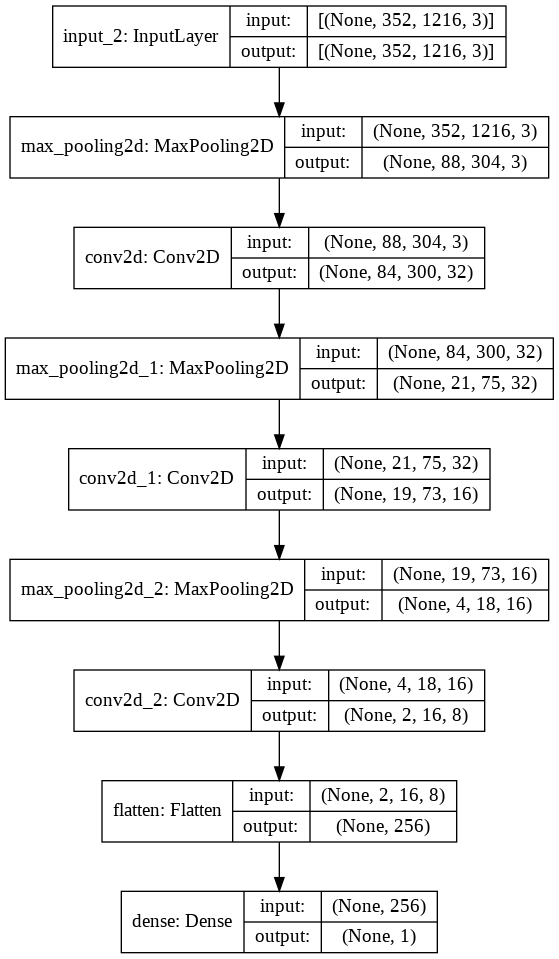

In [15]:

model=a_net()

model.model().summary()
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model.build_graph(), to_file=dot_img_file, show_shapes=True)

In [ ]:
net = build_model([352, 1216, 3])
net.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 350, 1214, 32)     896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 175, 607, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 175, 607, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 173, 605, 16)      4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 87, 303, 16)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 87, 303, 16)       64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 86, 302, 8)        5

In [20]:
# Hyperparameters
epochs = 20
batch_size = 64
k_init = tf.keras.initializers.random_normal(stddev=0.008, seed = 101)      
regularizer = tf.keras.regularizers.L2(1e-4)
b_init = tf.constant_initializer()

train_data,train_res, val_data,val_res = data_path(hazy_img_path = '/content/drive/MyDrive/kitti/hazy',percentage=1)
train, val = dataloader(train_data,train_res, val_data,val_res, batch_size)

optimizer = Adam(learning_rate = 1e-5)
#net = build_model([352, 1216, 3])
train_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "train loss")
val_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "val loss")

5400


In [21]:
def train_model(epochs, train, val, net, train_loss_tracker, val_loss_tracker, optimizer):
    
    for epoch in range(epochs):
        
        print("\nStart of epoch %d" % (epoch,), end=' ')
        start_time_epoch = time.time()
        start_time_step = time.time()

        for step, (train_batch_haze, train_res) in enumerate(train):

            with tf.GradientTape() as tape:

                train_logits = net(train_batch_haze, training = True)
                #print(train_logits.shape)
                train_res=np.expand_dims(train_res,axis=-1)
                loss = mean_squared_error(train_res, train_logits)

            grads = tape.gradient(loss, net.trainable_weights)
            optimizer.apply_gradients(zip(grads, net.trainable_weights))
            
            train_loss_tracker.update_state(train_res, train_logits)
            if step == 0:
                print('[', end='')
            if step % 64 == 0:
                print('=', end='')
        
        print(']', end='')
        print('  -  ', end='')
        print('Training Loss: %.4f' % (train_loss_tracker.result()), end='')
        
        for step, (val_batch_haze, val_res) in enumerate(val):
            val_logits = net(val_batch_haze, training = False)
            val_res=np.expand_dims(val_res,axis=-1)
            #print(val_logits.shape)
            #print("---------------------")
            val_loss_tracker.update_state(val_res, val_logits)
            #if step % 64 ==0:
                #display_img(net, val_batch_haze, val_batch_orig)
        print('  -  ', end='')
        print('Validation Loss: %.4f' % (val_loss_tracker.result()), end='')
        print('  -  ', end=' ')
        print("Time taken: %.2fs" % (time.time() - start_time_epoch))
        
        train_loss_tracker.reset_states()
        val_loss_tracker.reset_states()

In [49]:
%%time
train_model(2, train, val, model, train_loss_tracker, val_loss_tracker, tf.keras.optimizers.SGD(learning_rate = 1e-12))


Start of epoch 0 [==]  -  Training Loss: 0.0191  -  Validation Loss: 0.0220  -   Time taken: 170.89s

Start of epoch 1 [==]  -  Training Loss: 0.0191  -  Validation Loss: 0.0220  -   Time taken: 171.24s
CPU times: user 5min 18s, sys: 10.3 s, total: 5min 29s
Wall time: 5min 42s


In [50]:
model.save_weights('/content/drive/MyDrive/nets/prelim_model/simple_a_net/weights')
model.save('/content/drive/MyDrive/nets/prelim_model/simple_a_net')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/nets/prelim_model/simple_a_net/assets


In [ ]:
optimizer = Adam(learning_rate = 1e-3)

In [24]:
%%time
train_model(20, train, val, net, train_loss_tracker, val_loss_tracker, optimizer)

NameError: ignored

In [ ]:
optimizer = Adam(learning_rate = 1e-7)

In [ ]:
%%time
train_model(20, train, val, net, train_loss_tracker, val_loss_tracker, optimizer)


Start of epoch 0 [===]  -  Training Loss: 0.0286  -  Validation Loss: 0.0271  -   Time taken: 172.55s

Start of epoch 1 [===]  -  Training Loss: 0.0286  -  Validation Loss: 0.0271  -   Time taken: 171.65s

Start of epoch 2 [===]  -  Training Loss: 0.0286  -  Validation Loss: 0.0271  -   Time taken: 171.25s

Start of epoch 3 [===]  -  Training Loss: 0.0286  -  Validation Loss: 0.0271  -   Time taken: 171.01s

Start of epoch 4 [===]  -  Training Loss: 0.0286  -  Validation Loss: 0.0271  -   Time taken: 172.48s

Start of epoch 5 [===]  -  Training Loss: 0.0286  -  Validation Loss: 0.0271  -   Time taken: 171.11s

Start of epoch 6 [===]  -  Training Loss: 0.0286  -  Validation Loss: 0.0271  -   Time taken: 171.05s

Start of epoch 7 [===]  -  Training Loss: 0.0286  -  Validation Loss: 0.0271  -   Time taken: 170.93s

Start of epoch 8 [===]  -  Training Loss: 0.0286  -  Validation Loss: 0.0271  -   Time taken: 172.29s

Start of epoch 9 [===]  -  Training Loss: 0.0286  -  Validation Loss: 0.

In [ ]:
net.save('/content/drive/MyDrive/nets/prelim_model/a_net/0.0271')
net.save_weights('/content/drive/MyDrive/nets/prelim_model/a_net/weights/0.0271')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/nets/prelim_model/a_net/0.0271/assets


In [ ]:
net = build_model([352, 1216, 3])
net.load_weights('/content/drive/MyDrive/nets/prelim_model/a_net/weights/0.0271')

In [54]:
a=load_image('/content/drive/MyDrive/kitti/hazy/0000000005_14_0.81059.png')

In [55]:
model.predict(tf.expand_dims(a,axis=0))

array([[0.8153625]], dtype=float32)

In [ ]:
a.shape

TensorShape([352, 1216, 3])